# UPIT 
> A fastai/PyTorch package for *U*n-*P*aired *I*mage-to-image *T*ranslation currently with CycleGAN implementation.

Code available [here](https://github.com/tmabraham/UPIT).

[In a YouTube talk](https://www.youtube.com/watch?v=gT8-wDPLOBg) on Abhishek Thakur's channel, I introduced UPIT as a simple package for using the CycleGAN model. It was built with fastai and nbdev. Please watch the video for more information about the CycleGAN model and the package. Also see the [package documentation](https://tmabraham.github.io/UPIT/).


Here's a quick summary of the CycleGAN method:
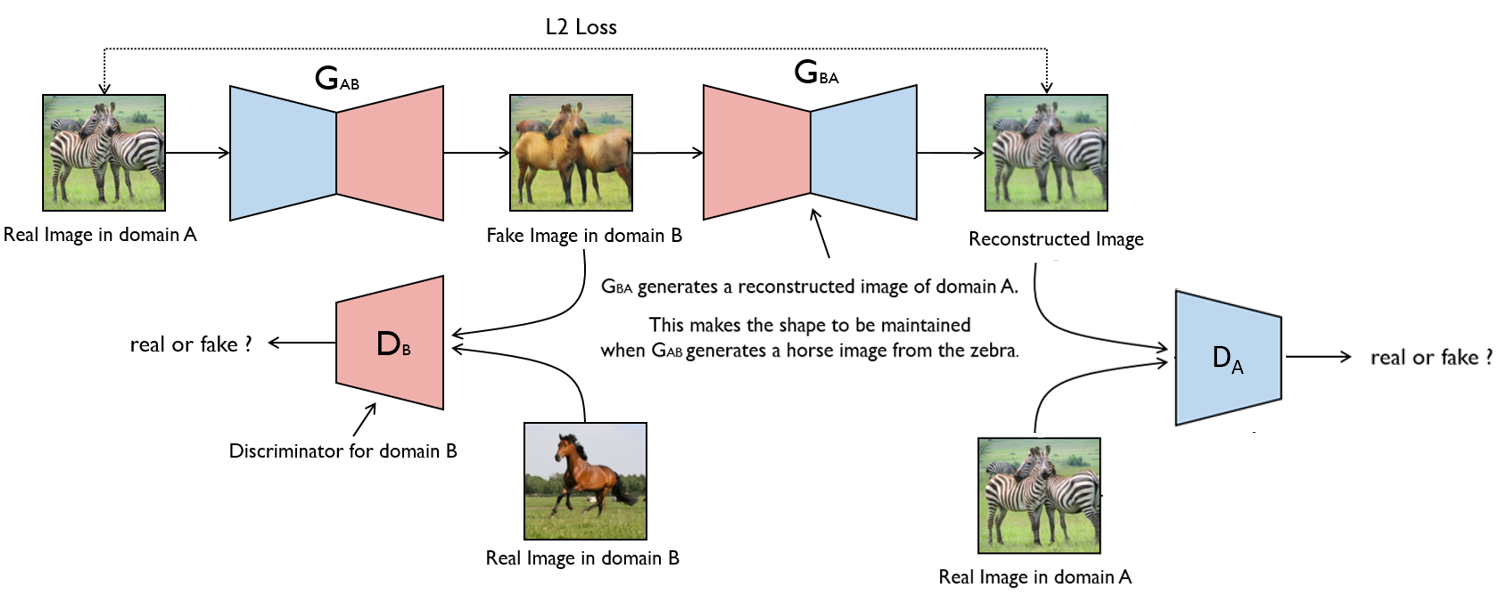

The idea is that the discriminator of domain B will provide a training signal for the generator to generate images with the style of domain B, while the cycle-consistency (reconstruction) loss will nudge the generator to maintain some aspects of the original image (like the shape and structure) in the final output image.

The generator uses the following ResNet-block-based architecture:
![generator](https://miro.medium.com/max/875/1*PVBSmRcCz9xfw-fCNi_q5g.png)

The discriminator uses a [70x70 PatchGAN](https://arxiv.org/abs/1611.07004):
![discriminator](https://miro.medium.com/max/875/1*46CddTc5JwkFW_pQb4nGZQ.png)

See my talk for more details.


## Install dependencies and package

In [2]:
# !pip install torch==1.6.0+cu101 torchvision==0.7.0+cu101 -f https://download.pytorch.org/whl/torch_stable.html > /dev/null
!pip install git+https://github.com/tmabraham/upit.git

  Cloning https://github.com/tmabraham/upit.git to c:\users\11027\appdata\local\temp\pip-req-build-_imsr40t
  Resolved https://github.com/tmabraham/upit.git to commit 7b53722934b0394226853208aa47aece296bc203
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
     -------------------------------------- 197.9/197.9 KB 6.1 MB/s eta 0:00:00
     ---------------------------------------- 60.1/60.1 KB ? eta 0:00:00
     --------------------------------------- 11.6/11.6 MB 13.4 MB/s eta 0:00:00
     ------------------------------------- 342.2/342.2 KB 10.7 MB/s eta 0:00:00
     ---------------------------------------- 84.4/84.4 KB ? eta 0:00:00
     ---------------------------------------- 6.6/6.6 MB 13.6 MB/s eta 0:00:00
     ------------------------------------- 181.6/181.6 KB 10.7 MB/s eta 0:00:00
     ---------------------------------------- 1.9/1.9 MB 13.9 MB/s eta 0:00:00
     -------------------------------------- 448.4/448.4 KB 9.3 MB/

  Running command git clone --filter=blob:none --quiet https://github.com/tmabraham/upit.git 'C:\Users\11027\AppData\Local\Temp\pip-req-build-_imsr40t'


## Imports

In [3]:
from upit.data.unpaired import *
from upit.models.cyclegan import *
from upit.train.cyclegan import *
from upit.inference.cyclegan import *
from fastai.vision.all import *


## Load data

In [4]:
trainA_path = Path('Data\photo_jpg')
trainB_path = Path('Data\monet_jpg')
print(f"There are {len(trainA_path.ls())} photos")
print(f"There are {len(trainB_path.ls())} Monet paintings")

There are 7038 photos
There are 300 Monet paintings


In the package, I provide a `get_dls` function that loads the dataset in the fastai-specific `DataLoaders` format given just the domain A and B folder paths. I also recently added subset functionality (just the number of desired files are provided). See [documentation](https://tmabraham.github.io/UPIT/data.unpaired/#get_dls) for more information.

In [5]:
dls = get_dls(trainA_path, trainB_path,load_size=256,crop_size=256)

Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `number_workers` is changed to 0 to avoid getting stuck
Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `number_workers` is changed to 0 to avoid getting stuck


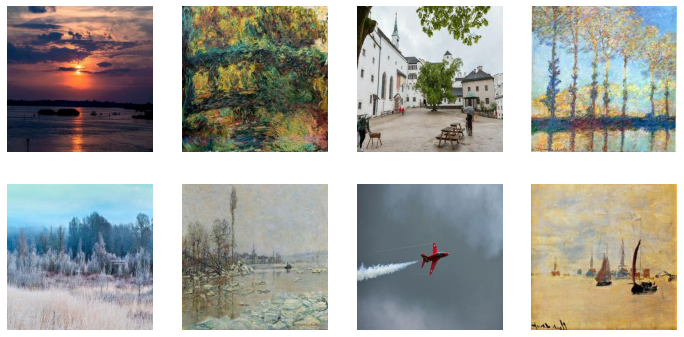

In [6]:
dls.show_batch()

## Model definition

I provide the `CycleGAN` class, which is just an `nn.Module` for generating converted images. See [documentation](https://tmabraham.github.io/UPIT/models.cyclegan/#Full-model) for more information. Note that the original paper uses `gen_blocks=9` but let's try a smaller model of `gen_blocks=3`.

In [7]:
cycle_gan = CycleGAN(3,3,64,gen_blocks=3)

We need to instantiate a fastai `Learner` object used to train a model (couples the data, model, and optimizer with callbacks, allowing for training and inference). I provide the `cycle_learner` function to do this. It will add the necessary `CycleGANTrainer` callback defined in my library, allowing for the generator-discriminator training. See the [documentation](https://tmabraham.github.io/UPIT/train.cyclegan/#cycle_learner) for further details.

In [8]:
learn = cycle_learner(dls, cycle_gan,opt_func=partial(Adam,mom=0.5,sqr_mom=0.999),show_img_interval=8)

If we want, we can use the `learn.lr_find()` command to find the best learning rate. We will find it is often around 1-2e-4, which is also the recommended learning rate in the original CycleGAN paper.

c:\Users\11027\AppData\Local\Programs\Python\Python39\lib\site-packages\fastai\learner.py:55: UserWarning: Could not load the optimizer state.
  if with_opt: warn("Could not load the optimizer state.")


SuggestedLRs(valley=3.0199516913853586e-05)

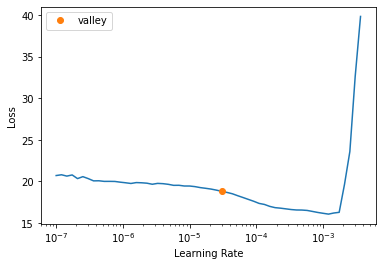

In [9]:
learn.lr_find()

The original CycleGAN paper uses a constant learning rate for half of training, and then linearly decaying to zero for the remainder of training. I added the `fit_flat_lin` method to implement this schedule. Note that the original paper runs for 200 epochs in total, but for now we run for 10 epochs.

epoch,train_loss,id_loss_A,id_loss_B,gen_loss_A,gen_loss_B,cyc_loss_A,cyc_loss_B,D_A_loss,D_B_loss,time
0,6.296411,0.938875,0.981471,0.373335,0.418619,2.071716,2.046380,0.210360,0.210360,20:21
1,5.219251,0.744642,0.748952,0.457972,0.465969,1.657977,1.571622,0.180528,0.180528,20:22
2,5.320339,0.669005,0.630482,0.474918,0.527140,1.459751,1.335923,0.181764,0.181764,20:22
3,4.528872,0.615304,0.587098,0.469945,0.684304,1.370336,1.211992,0.218155,0.218155,20:21
4,4.688069,0.575337,0.520553,0.427418,0.465764,1.272962,1.087924,0.203875,0.203875,20:21
5,4.777045,0.566804,0.513424,0.547754,0.649501,1.279877,1.068066,0.177607,0.177607,20:23
6,4.639774,0.565261,0.500513,0.602933,0.721001,1.269891,1.069777,0.131534,0.131534,20:23
7,4.083092,0.550271,0.451336,0.599637,0.541659,1.203269,1.014003,0.172631,0.172631,20:24
8,4.286129,0.502357,0.434387,0.436047,0.709428,1.142278,0.907848,0.177913,0.177913,20:23
9,4.208273,0.497655,0.415543,0.606522,0.755751,1.109168,0.904343,0.125226,0.125226,20:23


/opt/conda/lib/python3.7/site-packages/fastprogress/fastprogress.py:74: UserWarning: Your generator is empty.
  warn("Your generator is empty.")


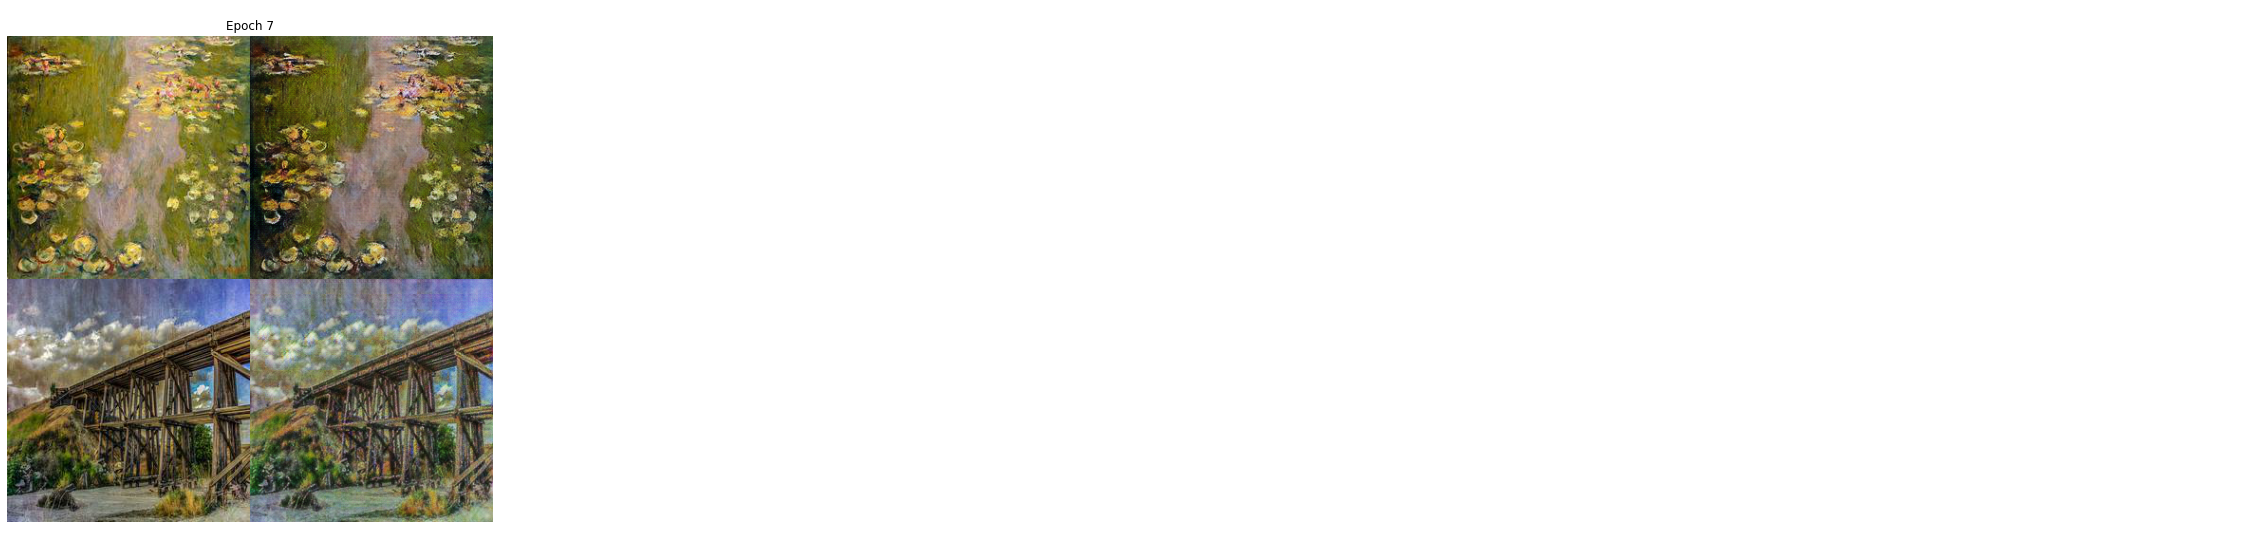

In [9]:
learn.fit_flat_lin(7,7,2e-4)

Using some fastai functions, we can view some predictions.

In [10]:
b = dls.one_batch()
_,_,preds = learn.get_preds(dl=[b], with_decoded=True)

Text(0.5, 0.98, 'Predictions')

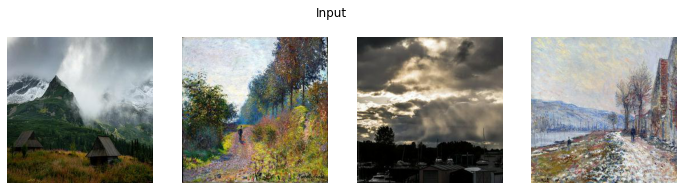

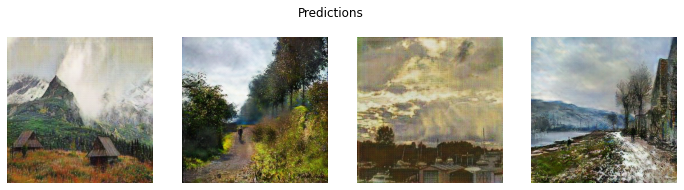

In [11]:
dls.show_batch((b[0], b[1]), max_n=2, show=True)
plt.suptitle('Input')
dls.show_batch((preds[1],preds[0]), max_n=2, show=True)
plt.suptitle('Predictions')

Finally, I provide `get_preds_cyclegan` to generate predictions from images in `testA_path` and save to `pred_path`. See [documentation](https://tmabraham.github.io/UPIT/inference.cyclegan/#get_preds_cyclegan).

In [12]:
testA_path = '../input/gan-getting-started/photo_jpg/'
pred_path = '../images/'

In [13]:
get_preds_cyclegan(learn,testA_path,pred_path,suffix='jpg')

Thankfully, all that's needed for submission is a zipped folder of those predicted images:

In [14]:
import shutil
shutil.make_archive("/kaggle/working/images", 'zip', "/kaggle/images")

'/kaggle/working/images.zip'

## Conclusion:

To summarize, my package makes CycleGAN training and inference easy and effortless. It simply takes effectively five lines of code:
```
dls = get_dls(trainA_path, trainB_path)
cycle_gan = CycleGAN(3,3,64,gen_blocks=3)
learn = cycle_learner(dls, cycle_gan,opt_func=partial(Adam,mom=0.5,sqr_mom=0.999),show_img_interval=8)
learn.fit_flat_lin(12,12,2e-4)
get_preds_cyclegan(learn, testA_path, preds_path)
```

Please upvote this kernel if you found this helpful! Additionally, please check out my [talk](https://www.youtube.com/watch?v=gT8-wDPLOBg) for more information! 

I plan to implement other unpaired image-to-image translation models in this public library. I am currently planning to add:
- DualGAN
- GANILLA
- DiscoGAN

**Comment below** if you have suggestions for other **unpaired image-to-image translation** models to add.

Additionally, I plan to add easier methods for viewing results (including during training) and better support for using custom models. **Let me know if you have any suggested features!**

## Acknowledgements

Thank you to Andrew Shaw for his help porting over the fastai v1 code. Thank you to the fast.ai team for providing the original fastai v1 version of the CycleGAN.

Diagrams were taken (w/ or w/o modification) from [here](https://github.com/yunjey/mnist-svhn-transfer) and [here](https://towardsdatascience.com/cyclegan-learning-to-translate-images-without-paired-training-data-5b4e93862c8d).